In [6]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import joblib

PROJECT_ROOT = Path(__file__).resolve().parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.eval.evaluation.style import apply_shap_style, get_model_style, SHAP_BLUE, SHAP_RED, save_plot

apply_shap_style()

In [2]:
TRAIN_FILE = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/asinh1-reg/splits/train.parquet"
SCALER_FILE = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/asinh1-reg/scaler/scaler.joblib"

RAW_DATA_FILE = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/raw-reg/splits/train.parquet"

COLS_OF_INTEREST = ["snapshot_times", "delivery_start", "label_5min", "bid_ask_spread", "orderbook_slope_ask",
                    "liquidity_best_ask", "mp_wmp_return_diff_prev_1min", "mid_price_return_prev_5min_RV_60s"]

In [3]:
# inti scaler
scaler = joblib.load(SCALER_FILE)

In [4]:
# load data
train_df = pd.read_parquet(TRAIN_FILE, columns=COLS_OF_INTEREST)

# subsample for faster processing
train_df = train_df.sample(n=3_000_000, random_state=42)

In [5]:
# reverse scaling

# add ttd col
train_df[scaler.ttd_col] = (train_df["delivery_start"] - train_df["snapshot_times"]).dt.total_seconds() / 60.0

train_df_raw = scaler.inverse_transform(train_df)

Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 220.47it/s]


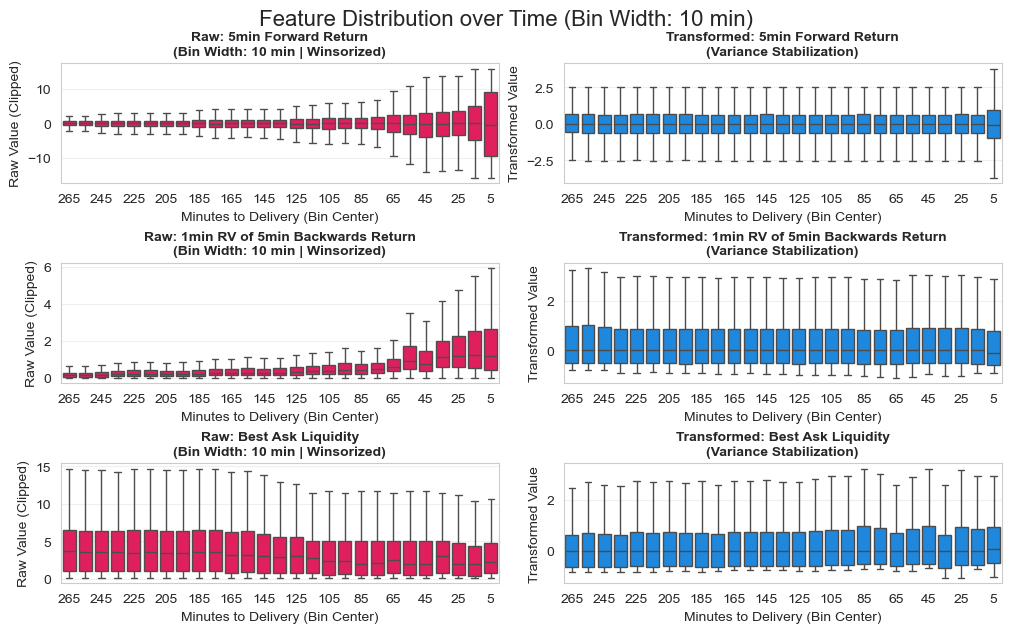

✅ Grafik gespeichert in: figures/variance_stabilization_comparison


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def plot_variance_stabilization(df_raw, df_scaled, features,
                                ttd_col="ttd_min",
                                scaler_name="Transformed",
                                bin_width_min=5,  # <--- NEU: Breite eines Bins in Minuten
                                sample_n=100000,
                                winsor_limits=(0.01, 0.99)):
    """
    Vergleicht Raw vs. Scaled Features mittels Boxplots.
    Die X-Achse wird nun durch feste Minuten-Intervalle (bin_width_min) definiert.
    """

    # 1. Datenvorbereitung & Sampling
    if len(df_raw) > sample_n:
        sampled_indices = df_raw.sample(n=sample_n, random_state=42).index
        data_raw = df_raw.loc[sampled_indices].copy()
        data_scaled = df_scaled.loc[sampled_indices].copy()
    else:
        data_raw = df_raw.copy()
        data_scaled = df_scaled.copy()

    # 2. TTD Berechnung
    if ttd_col not in data_raw.columns:
        if "delivery_start" in data_raw.columns and "snapshot_times" in data_raw.columns:
            data_raw[ttd_col] = (data_raw["delivery_start"] - data_raw["snapshot_times"]).dt.total_seconds() / 60
        else:
            pass

    # 3. Binning nach fester Breite (Minuten)
    # Maximalen TTD Wert finden (z.B. 118.5 Minuten)
    max_ttd = data_raw[ttd_col].max()

    # Wir runden auf den nächsten vollen Bin auf, um alles abzudecken
    # np.arange(start, stop, step) -> Wir gehen von 0 bis max + breite
    bins_edges = np.arange(0, max_ttd + bin_width_min, bin_width_min)

    # Schneiden der Bins
    data_raw["bin_obj"] = pd.cut(data_raw[ttd_col], bins=bins_edges)

    # Labeling: Wir nehmen den Mittelpunkt des Intervalls als Label
    # Z.B. Intervall (10, 15] -> Label 12
    def get_midpoint(interval):
        if isinstance(interval, float): return 0
        return int(interval.mid)

    data_raw["bin_label"] = data_raw["bin_obj"].apply(get_midpoint)

    # Übertragen auf Scaled DF (1:1 Zuordnung)
    data_scaled["bin_label"] = data_raw["bin_label"]

    # Sortieren: Von viel Zeit (links) nach wenig Zeit (rechts)
    sorted_labels = sorted(data_raw["bin_label"].dropna().unique(), reverse=True)

    # 4. Plot Setup
    n_features = len(features)
    fig, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(10, 2 * n_features), layout='constrained')

    if n_features == 1:
        axes = np.expand_dims(axes, axis=0)

    # 5. Loop über Features
    for i, feat in enumerate(features):
        ax_raw = axes[i, 0]
        ax_sc = axes[i, 1]

        # --- A) RAW (Winsorized) ---
        lower = data_raw[feat].quantile(winsor_limits[0])
        upper = data_raw[feat].quantile(winsor_limits[1])
        feat_winsor = f"{feat}_winsor"
        data_raw[feat_winsor] = data_raw[feat].clip(lower=lower, upper=upper)

        sns.boxplot(data=data_raw, x="bin_label", y=feat_winsor, ax=ax_raw,
                    order=sorted_labels, showfliers=False, color=SHAP_RED)

        ax_raw.set_title(f"Raw: {feat}\n(Bin Width: {bin_width_min} min | Winsorized)",
                         fontweight='bold', fontsize=10)
        ax_raw.set_ylabel("Raw Value (Clipped)")
        ax_raw.grid(True, axis='y', alpha=0.3)

        # --- B) SCALED ---
        sns.boxplot(data=data_scaled, x="bin_label", y=feat, ax=ax_sc,
                    order=sorted_labels, showfliers=False, color=SHAP_BLUE)

        ax_sc.set_title(f"{scaler_name}: {feat}\n(Variance Stabilization)", fontweight='bold', fontsize=10)
        ax_sc.set_ylabel("Transformed Value")
        ax_sc.grid(True, axis='y', alpha=0.3)

        # --- C) ACHSEN BEREINIGUNG ---
        for ax in [ax_raw, ax_sc]:
            ax.set_xlabel("Minutes to Delivery (Bin Center)")

            # Smart Ticks: Zeige maximal 15 Labels an, egal wie klein die Bin-Breite ist
            xtick_labels = ax.get_xticklabels()
            total_ticks = len(xtick_labels)

            if total_ticks > 15:
                step = total_ticks // 12  # Zeige ca. jeden 12. Teil
                for idx, label in enumerate(xtick_labels):
                    if idx % step == 0:
                        label.set_visible(True)
                    else:
                        label.set_visible(False)

            ax.tick_params(axis='x', rotation=0)

    plt.suptitle(f"Feature Distribution over Time (Bin Width: {bin_width_min} min)", fontsize=16, y=1.03)
    plt.show()

    save_plot(fig, "variance_stabilization_comparison")


# --- ANWENDUNG ---

column_rename_map = {
    "label_5min": "5min Forward Return",
    "mid_price_return_prev_5min_RV_60s": "1min RV of 5min Backwards Return",
    "liquidity_best_ask": "Best Ask Liquidity",
}

# rename cols for convenience
train_df_raw = train_df_raw.rename(columns=column_rename_map)
train_df = train_df.rename(columns=column_rename_map)

# Beispielaufruf:
features_to_check = column_rename_map.values()
plot_variance_stabilization(train_df_raw, train_df, features_to_check, bin_width_min=10, sample_n=6000000,
                            winsor_limits=(0.01, 0.99))